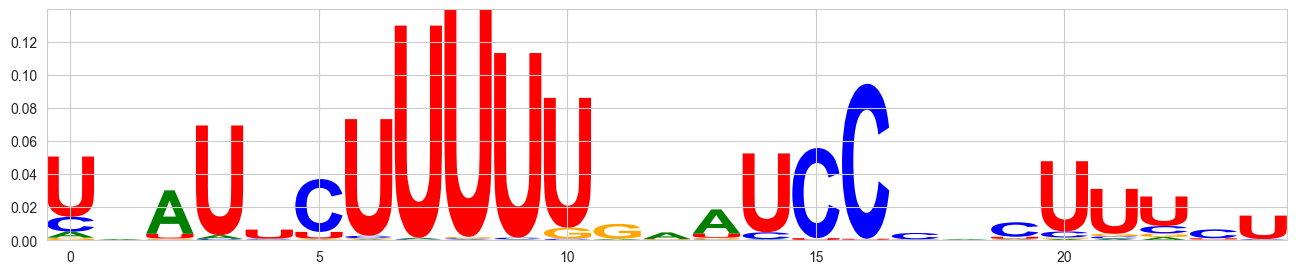

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import pandas as pd
import numpy as np
from collections import Counter
bidx, eidx = 72, 97
name,seq_len,suff = "core6-merge",25,"" # _seq core6-merge pl3-1-2
datadir=f"/data/home/jinyalong/data/sev_241023/results/{name}/{name}_"
# bidx, eidx = 0, 119
# name,seq_len,suff = "pl3-1-2",118,"" # _seq core6-merge pl3-1-2
# datadir=f"/data/home/jinyalong/data/sev_240624/results/{name}/{name}_"

def random_seqs():
    sdf = pd.read_csv(f"{datadir}final{suff}.csv")
    sdf["seq"] = sdf["seq"].apply(lambda x: x[bidx:eidx])
    sdf = sdf[sdf.seq.str.len()==seq_len]
    frac = sdf["plasmid_counts"].sum()/sdf["rna_counts"].sum()
    sdf["abs_score"]=sdf["rna_counts"]/sdf["plasmid_counts"]*frac
    cnter = Counter()
    for s in sdf.seq.values:
        cnter.update(s.lower())
    total = sum(cnter.values())
    bgnts = {k:v/total for k,v in cnter.items()}
    entropy = sum(-v*np.log2(v) for v in bgnts.values())
    return sdf,bgnts,entropy


class Tokenizer(object):

    def __init__(self,chars="acgt"):
        self.length = len(chars)
        self.chars = chars+"n"
        self.dchars = {c:[0]*self.length for c in self.chars}
        for i, c in enumerate(chars):
            self.dchars[c][i]=1

    def corpus(self,i):
        idx = i.argmax()
        return self.chars[idx]

    def decode(self, X,seq_len=None):
        mask = np.max(X,axis=-1)==0
        X = np.argmax(X,axis=-1)
        X = np.where(mask,-1,X)
        seqs = []
        for x in X:
            seq = "".join([self.chars[c] for c in x])
            seqs.append(seq)
        return seqs

    def encode(self,seqs,seq_len=None):
        vectors = np.empty([len(seqs),seq_len,self.length])
        for i,seq in enumerate(seqs):
            seq = seq[:seq_len].lower()
            lst = [self.dchars[x] for x in seq]
            if seq_len>len(seq):
                lst += [self.dchars['n']]*(seq_len-len(seq))
            a = np.array(lst)
            vectors[i] = a
        return vectors


class MotifUtils(object):

    def __init__(self, onehots, bg_pfm=None, weight=None, smooth_value=1e-10):
        self.onehots = onehots
        self.shape = self.onehots.shape[-2:]
        self.bg_pfm = bg_pfm if bg_pfm is not None else onehots.sum(axis=0) if weight is not None else np.full(self.shape,0.25)
        self.weight = weight.reshape((-1,1,1)) if weight is not None else np.full((onehots.shape[0],1, 1), 1)
        self.pfm = np.multiply(self.onehots, self.weight).sum(axis=0)
        self.smooth_value = smooth_value

    @property
    def ppm(self):
        pfm = self.pfm
        return pfm / pfm.sum(axis=-1)[:, np.newaxis]

    @property
    def pwm(self):
        ppm = self.ppm
        bg_ppm = self.bg_pfm / self.bg_pfm.sum(axis=-1)[:, np.newaxis]
        return np.log2(ppm/bg_ppm)

    def kl(self,columns=["U","G","C","A"]):
        ppm = self.ppm
        bg_ppm = self.bg_pfm / self.bg_pfm.sum(axis=-1)[:, np.newaxis]
        pwm = np.log2(ppm / bg_ppm)
        ht_mat = (ppm * pwm).sum(axis=1).reshape((-1, 1))
        kl = np.multiply(ppm, ht_mat)
        return pd.DataFrame(data=kl, columns=columns)


sdf,bgnts,entropy = random_seqs()
token = Tokenizer()
onehots = token.encode(sdf.seq.values,seq_len)
motif = MotifUtils(onehots, weight=sdf.abs_score.values)
pwm=motif.kl()
f, axs = plt.subplots(figsize=(16,3))
logo =logomaker.Logo(pwm,ax=axs)
plt.show()
